In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import pandas as pd
import numpy as np
import yfinance as yf
import pycwt as wavelet
import datetime as datetime

import matplotlib.pyplot as plt
from pycwt.helpers import find
from matplotlib.image import NonUniformImage
import matplotlib.dates as mdates
import matplotlib.ticker as pltticker

# Loading Data

In [2]:
def standardize(series):
    return (series-series.mean())/series.std()

source = pd.ExcelFile("./data/eqt.xlsx")
series = {}
for sheet in source.sheet_names:
    series[sheet] = source.parse(sheet_name=sheet, parse_dates = True)
    
intraday = []
for ticker in list(series.keys())[:6]:
    intraday.append(series[ticker].set_index("Date").add_suffix("_"+ticker))
    series[ticker] = series[ticker].set_index("Date")

volatility = list(series.keys())[6:9]
short_index = list(series.keys())[9:11]
sentiment = list(series.keys())[11:15]
gme_twitter = list(series.keys())[15]


source.close()
del source

###Warning missing data from open to close of GME ticker from Bloomberg , outer join used
##NOK also contains missung data

## News Sentiment and GME daily quotes for news sentiment comparison
gme_news_sent = series['GME Sent'].set_index("Date")
gme_news_sent['net'] = gme_news_sent.iloc[:,5] + gme_news_sent.iloc[:,6]
gme_daily_news = yf.Ticker("GME").history(start = gme_news_sent.index.min(), end = gme_news_sent.index.max())
gme_news_sent = gme_news_sent.loc[gme_daily_news.index]
gme_daily_news = standardize(gme_daily_news.Close.pct_change())
gme_daily_news = gme_daily_news[gme_news_sent.net.dropna().index]

## Sentiment datasets
#raw = VADER sentiment on raw submission titles (noncleaned)
#lexadj = VADER sentiment with adjusted LEXICON
sentiment_raw = pd.read_csv("./data/sentiment_scores_rawtext.csv", index_col = [0], parse_dates = True).sort_index()
sentiment_lexadj = pd.read_csv("./data/sentiment_scores_lexadj.csv", index_col = [0], parse_dates = True).sort_index()
sampled_sent_lexadj = sentiment_lexadj.resample("30min").agg("sum")
gme_daily = yf.Ticker("GME").history(start = sentiment_lexadj.index.min(), end = sentiment_lexadj.index.max()+datetime.timedelta(days=1))
data = {}
## Creating aggregated dataset
for ticker in list(series.keys())[:6]:
    data[ticker] = standardize(series[ticker].Close.pct_change())

data['Sentiment'] = sampled_sent_lexadj.compound

data = pd.concat(data, axis = 1).dropna(how = "any")

# GME Sentiment Waves

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



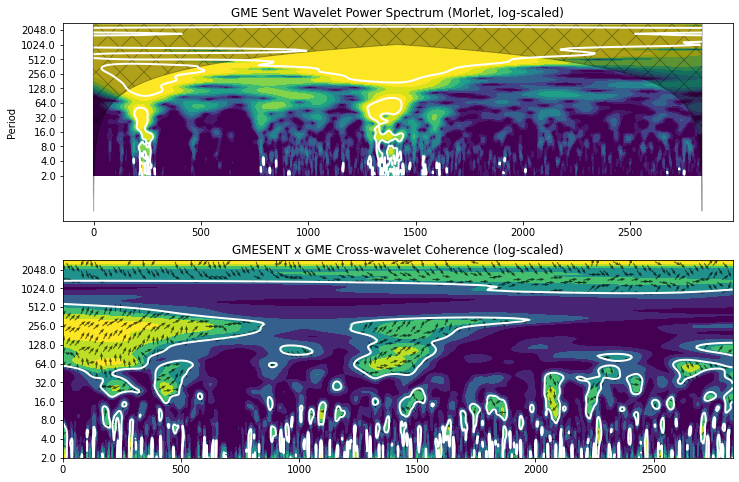

In [3]:
data1 = dict(name='GameStop Sentiment', nick='GME Sent', data = data.Sentiment)
data2 = dict(name='GameStop', nick='GME', data = data.GME)
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

W12, cross_coi, freq, signif = wavelet.xwt(y1 = s1, y2 = s2, dt = dt, dj = 1/12, s0 = -1, J = -1,
                                           significance_level=0.8646,
                                           wavelet = "morlet", normalize = True
                                          )
cross_power = np.abs(W12)**2
cross_sig = np.ones([1,n]) * signif[:, None]
cross_sig = cross_power/cross_sig #significant power if ratio > 1
cross_period = 1/freq



WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8))
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
# ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)


extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

ax2.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax2.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 20):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::8]:
            ax2.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)

# ax2.quiver(t1[1490], np.log2(cor_period)[80], u[80, 1490], v[80, 1490],
#            units = "width", angles = 'uv', pivot = 'mid', width = 0.001,scale = 20,
#            headwidth = 3, headlength = 4, alpha = 0.85, color = "k"
#           )
yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax2.set_title("GMESENT x GME Cross-wavelet Coherence (log-scaled)")
ax2.set_yticks(np.log2(yticks_cor))
ax2.set_yticklabels(yticks_cor)
plt.show()

# GME AMC Waves

NOTE: WCT significance loaded from cache.



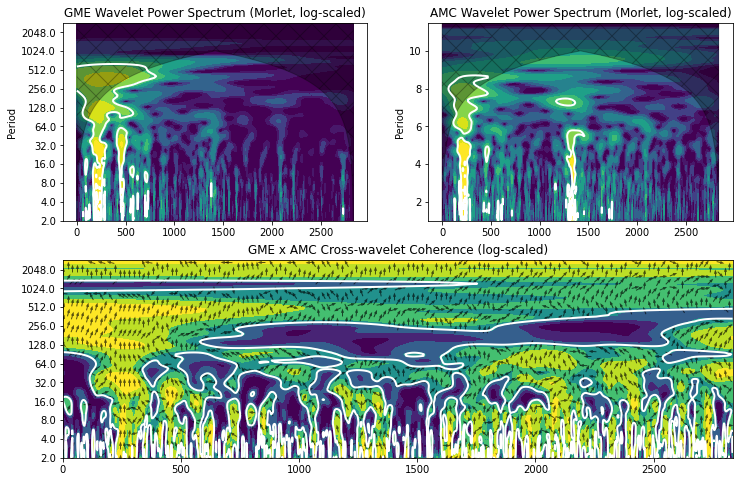

In [4]:
data1 = dict(name="Gamestop", nick='GME', data = data.GME)
data2 = dict(name='AMC', nick='AMC', data = data.AMC)
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])
# s1 = np.concatenate([np.repeat(1e-5,len(data1['data'])/10), data1['data']])
# s2 = np.concatenate([np.repeat(1e-5,len(data2['data'])/10), data2['data']])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

# fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8), dpi = 72)
fig = plt.figure(figsize = (12,8), dpi = 72)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)


ax2.contourf(t2, np.log2(period2), np.log2(power2), np.log2(levels), extend = "both", cmap = "viridis")
extent2 = [t2.min(), t2.max(), 0, max(period2)]
ax2.contour(t2, np.log2(period2), sig95_2, [-99, 1], colors = "w", linewidths = 2, extent = extent2)

ax2.fill(np.concatenate([t2, t2[-1:] + dt, t2[-1:] + dt, t2[:1] - dt, t2[:1] - dt]),
        np.concatenate([np.log2(coi2), [1e-9], np.log2(period2)[-1:], np.log2(period2)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax2.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data2['nick'], mother.name))
ax2.set_ylabel("Period")
ax2.set_ylim((np.log2(period2).min(),np.log2(period2).max()))
# yticks = 2**np.arange(np.ceil(np.log2(period2.min())),
#                         np.ceil(np.log2(period2.max())))

# ax2.set_yticks(np.log2(yticks))
# ax2.set_yticklabels(yticks)


extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

ax3.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax3.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 20):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::8]:
            ax3.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)

yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax3.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax3.set_yticks(np.log2(yticks_cor))
ax3.set_yticklabels(yticks_cor)
plt.show()

# GME BB WAVES

NOTE: WCT significance loaded from cache.



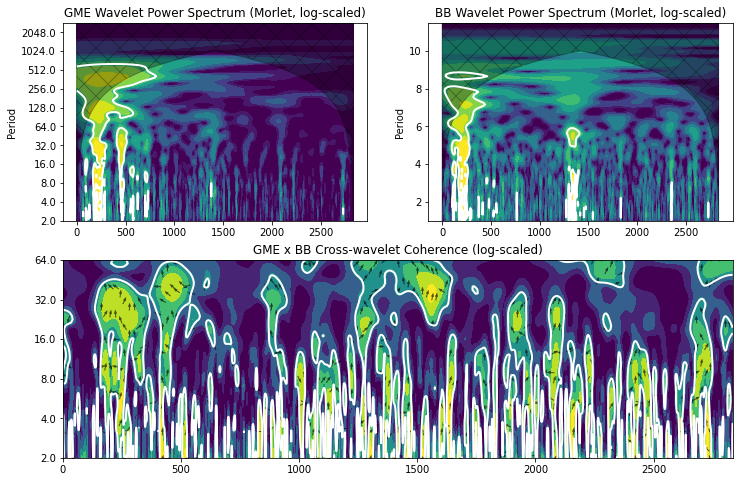

In [5]:
data1 = dict(name="Gamestop", nick='GME', data = data.GME)
data2 = dict(name='BlackBerry', nick='BB', data = data.BB)
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])
# s1 = np.concatenate([np.repeat(1e-5,len(data1['data'])/10), data1['data']])
# s2 = np.concatenate([np.repeat(1e-5,len(data2['data'])/10), data2['data']])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

# fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8), dpi = 72)
fig = plt.figure(figsize = (12,8), dpi = 72)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)


ax2.contourf(t2, np.log2(period2), np.log2(power2), np.log2(levels), extend = "both", cmap = "viridis")
extent2 = [t2.min(), t2.max(), 0, max(period2)]
ax2.contour(t2, np.log2(period2), sig95_2, [-99, 1], colors = "w", linewidths = 2, extent = extent2)

ax2.fill(np.concatenate([t2, t2[-1:] + dt, t2[-1:] + dt, t2[:1] - dt, t2[:1] - dt]),
        np.concatenate([np.log2(coi2), [1e-9], np.log2(period2)[-1:], np.log2(period2)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax2.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data2['nick'], mother.name))
ax2.set_ylabel("Period")
ax2.set_ylim((np.log2(period2).min(),np.log2(period2).max()))
# yticks = 2**np.arange(np.ceil(np.log2(period2.min())),
#                         np.ceil(np.log2(period2.max())))

# ax2.set_yticks(np.log2(yticks))
# ax2.set_yticklabels(yticks)


extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

ax3.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax3.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 20):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::8]:
            ax3.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)

yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax3.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax3.set_yticks(np.log2(yticks_cor))
ax3.set_yticklabels(yticks_cor)
ax3.set_ylim((1,6))
plt.show()

# GME CLOV Waves

NOTE: WCT significance loaded from cache.



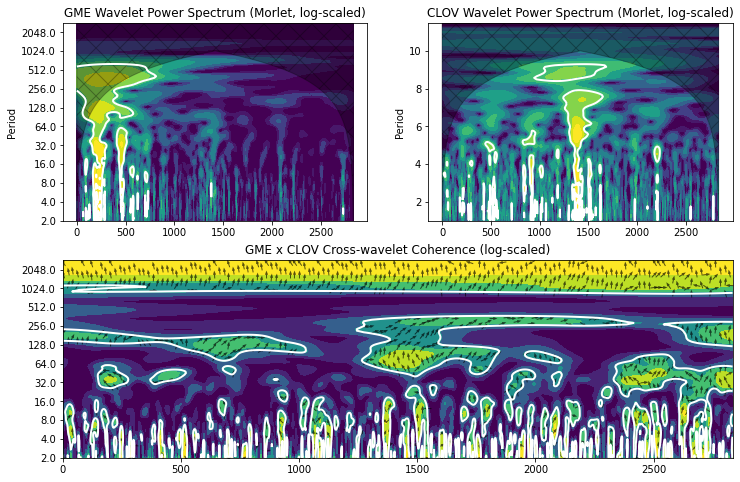

In [6]:
data1 = dict(name="Gamestop", nick='GME', data = data.GME)
data2 = dict(name='Clover Health', nick='CLOV', data = data.CLOV)
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])
# s1 = np.concatenate([np.repeat(1e-5,len(data1['data'])/10), data1['data']])
# s2 = np.concatenate([np.repeat(1e-5,len(data2['data'])/10), data2['data']])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

# fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8), dpi = 72)
fig = plt.figure(figsize = (12,8), dpi = 72)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)


ax2.contourf(t2, np.log2(period2), np.log2(power2), np.log2(levels), extend = "both", cmap = "viridis")
extent2 = [t2.min(), t2.max(), 0, max(period2)]
ax2.contour(t2, np.log2(period2), sig95_2, [-99, 1], colors = "w", linewidths = 2, extent = extent2)

ax2.fill(np.concatenate([t2, t2[-1:] + dt, t2[-1:] + dt, t2[:1] - dt, t2[:1] - dt]),
        np.concatenate([np.log2(coi2), [1e-9], np.log2(period2)[-1:], np.log2(period2)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax2.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data2['nick'], mother.name))
ax2.set_ylabel("Period")
ax2.set_ylim((np.log2(period2).min(),np.log2(period2).max()))
# yticks = 2**np.arange(np.ceil(np.log2(period2.min())),
#                         np.ceil(np.log2(period2.max())))

# ax2.set_yticks(np.log2(yticks))
# ax2.set_yticklabels(yticks)


extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

ax3.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax3.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 20):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::8]:
            ax3.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)

yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax3.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax3.set_yticks(np.log2(yticks_cor))
ax3.set_yticklabels(yticks_cor)
plt.show()

## GME Sentiment Daily Series

In [7]:
sent_daily = sampled_sent_lexadj.resample("1D").agg("sum")
sent_daily = sent_daily.loc[[row in gme_daily.index for row in sent_daily.index]]

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



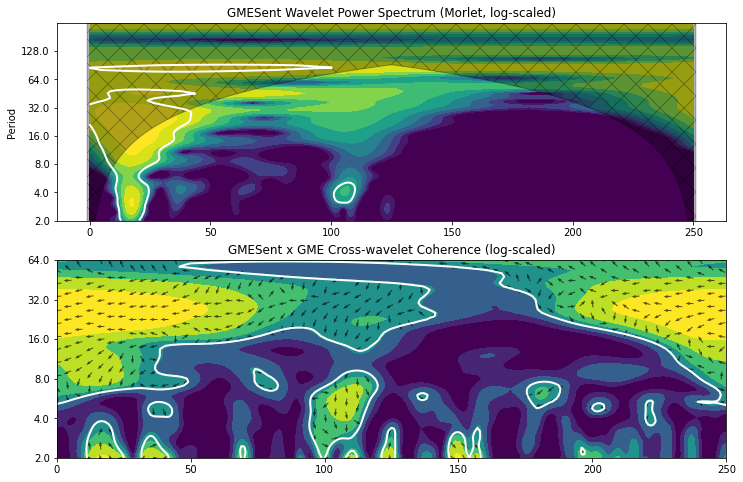

In [8]:
data1 = dict(name="Sentiment Daily", nick='GMESent', data = sent_daily.compound.dropna())
data2 = dict(name='GME', nick='GME', data = gme_daily.Close.pct_change().dropna())
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8), dpi = 72)
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)


extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

ax2.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax2.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 4):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::4]:
            ax2.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)

yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax2.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax2.set_yticks(np.log2(yticks_cor))
ax2.set_yticklabels(yticks_cor)
ax2.set_ylim((1,6))
plt.show()

# NEWS SENTIMENT

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



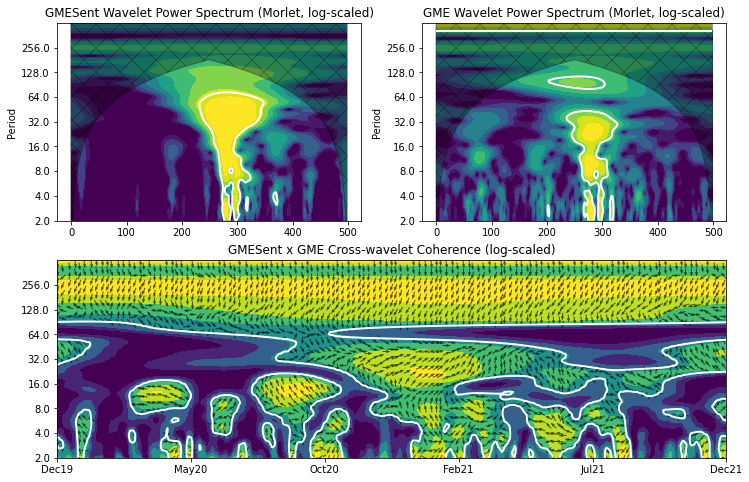

In [9]:

data1 = dict(name="Sentiment Daily", nick='GMESent', data = gme_news_sent.net.dropna()[1:])
data2 = dict(name='GME', nick='GME', data = gme_daily_news.dropna())
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)


fig = plt.figure(figsize = (12,8), dpi = 72)
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)


levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)


ax2.contourf(t2, np.log2(period2), np.log2(power2), np.log2(levels), extend = "both", cmap = "viridis")
extent2 = [t2.min(), t2.max(), 0, max(period2)]
ax2.contour(t2, np.log2(period2), sig95_2, [-99, 1], colors = "w", linewidths = 2, extent = extent2)

ax2.fill(np.concatenate([t2, t2[-1:] + dt, t2[-1:] + dt, t2[:1] - dt, t2[:1] - dt]),
        np.concatenate([np.log2(coi2), [1e-9], np.log2(period2)[-1:], np.log2(period2)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax2.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data2['nick'], mother.name))
ax2.set_ylabel("Period")
ax2.set_ylim((np.log2(period2).min(),np.log2(period2).max()))
yticks = 2**np.arange(np.ceil(np.log2(period2.min())),
                        np.ceil(np.log2(period2.max())))

ax2.set_yticks(np.log2(yticks))
ax2.set_yticklabels(yticks)


extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

t1 = data1['data'].index
ax3.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax3.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 4):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::4]:
            ax3.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)

yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax3.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax3.set_yticks(np.log2(yticks_cor))
ax3.set_yticklabels(yticks_cor)

# ax3.set_xticks(data2['data'].index)
# ax3.set_xticklabels(data2['data'].index)
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
ax3.xaxis.set_major_locator(pltticker.LinearLocator(numticks = 6))
# ax3.set_ylim((1,6)) limits need to be set in original log scale 2^6 = 64 --> ylim 1,6
plt.show()

# AMC SENTIMENT

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



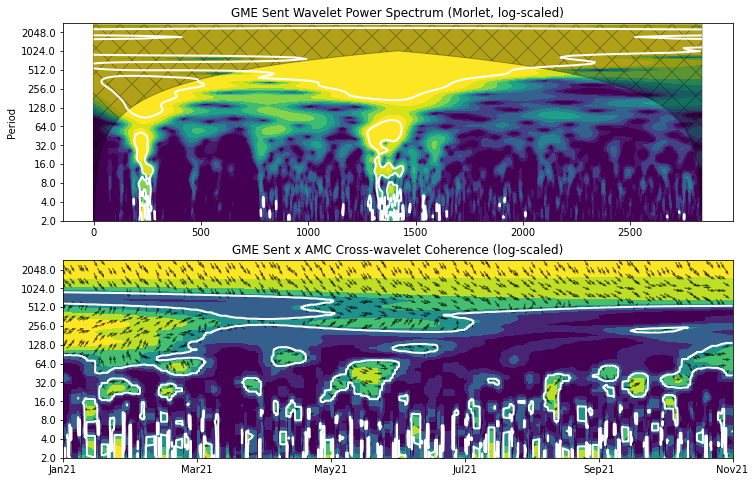

In [10]:
data1 = dict(name='Sentiment', nick='GME Sent', data = data.Sentiment)
data2 = dict(name='AMC', nick='AMC', data = data.AMC)
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8), dpi = 72)
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

t1 = data1['data'].index
ax2.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax2.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 20):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::8]:
            ax2.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)



yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax2.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax2.set_yticks(np.log2(yticks_cor))
ax2.set_yticklabels(yticks_cor)
# ax2.set_xticklabels(data1['data'].index)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
ax2.xaxis.set_major_locator(pltticker.LinearLocator(numticks = 6))
# ax2.set_ylim((1,6))
plt.show()

# Volatility WAVES

In [11]:
for i in volatility:
    series[i].Date = [datetime.datetime.strptime(i, "%m/%d/%y") for i in series[i].Date]
    series[i] = series[i].set_index("Date")
vol_data = pd.concat([series.get(i) for i in volatility], axis = 1)
vol_data = vol_data.sort_index()

In [12]:
### Detrend volatility series
x = np.arange(0, vol_data.shape[0])
p = np.polyfit(x, vol_data.iloc[:,1],2)
hist_vol_detrended = vol_data.iloc[:,1] - np.polyval(p,x)
hist_vol_detrended = hist_vol_detrended/hist_vol_detrended.std()

impl_vol_detrended = vol_data.iloc[:, 2] - np.polyval(np.polyfit(x, vol_data.iloc[:, 2],2), x)
impl_vol_detrended /= impl_vol_detrended.std()

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



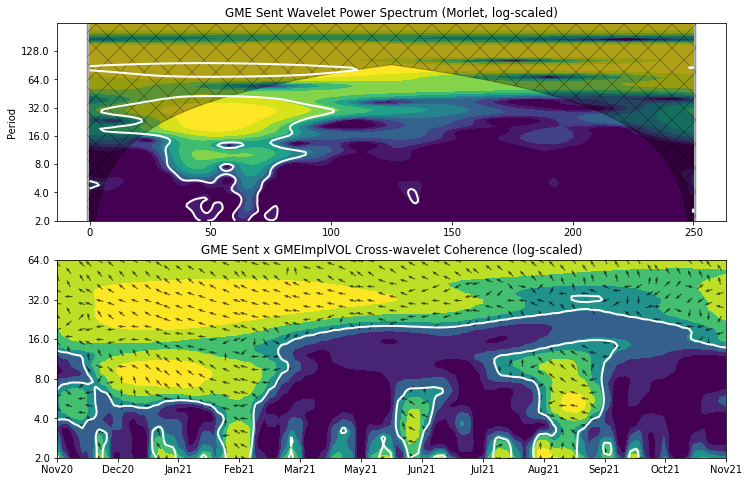

In [13]:
data1 = dict(name='Sentiment', nick='GME Sent', data = impl_vol_detrended[1:])
data2 = dict(name='GME Implied Volatility', nick='GMEImplVOL', data = standardize(vol_data.iloc[:,0].pct_change().dropna()))
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8), dpi = 72)
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

t1 = data1['data'].index
ax2.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
ax2.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 4):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::4]:
            ax2.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)



yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
ax2.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax2.set_yticks(np.log2(yticks_cor))
ax2.set_yticklabels(yticks_cor)
# ax2.set_xticklabels(data1['data'].index)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
ax2.xaxis.set_major_locator(pltticker.LinearLocator(numticks = 12))
ax2.set_ylim((1,6))
plt.show()

# INTRADAY VOLATILITY WAVES

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



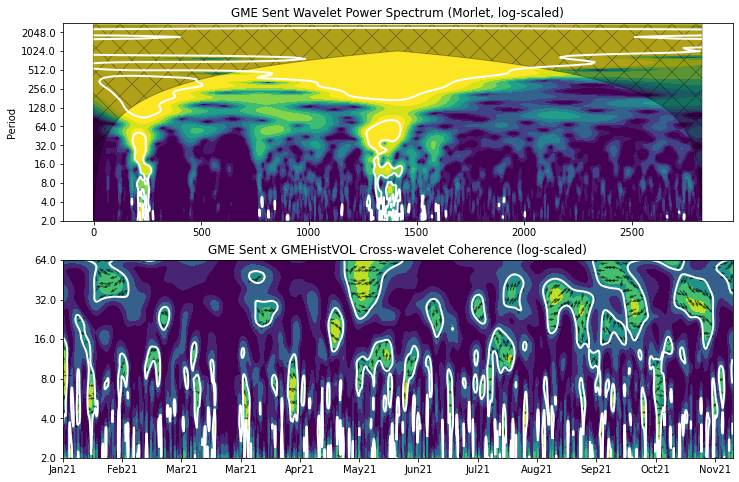

<Figure size 432x288 with 0 Axes>

In [14]:
data1 = dict(name='Sentiment', nick='GME Sent', data = data.Sentiment[9:])
data2 = dict(name='GME Hist Volatility', nick='GMEHistVOL', data = data.rolling(10).std().AMC.dropna())
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7/dj #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

fig, (ax1,ax2) = plt.subplots(nrows = 2, ncols = 1, figsize = (12,8), dpi = 72)
# fig = plt.figure(figsize = (11,8))
# ax = plt.axes([0.1, 0.37, 0.65, 0.28], sharex=ax)

levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16]

ax1.contourf(t1, np.log2(period1), np.log2(power1), np.log2(levels), extend = "both", cmap = "viridis")
extent1 = [t1.min(), t1.max(), 0, max(period1)]
ax1.contour(t1, np.log2(period1), sig95_1, [-99, 1], colors = "w", linewidths = 2, extent = extent1)

ax1.fill(np.concatenate([t1, t1[-1:] + dt, t1[-1:] + dt, t1[:1] - dt, t1[:1] - dt]),
        np.concatenate([np.log2(coi1), [1e-9], np.log2(period1)[-1:], np.log2(period1)[-1:], [1e-9]]),
        color = 'k', alpha = .3, hatch = "x"
       )
ax1.set_title("{} Wavelet Power Spectrum ({}, log-scaled)".format(data1['nick'], mother.name))
ax1.set_ylabel("Period")
ax1.set_ylim((np.log2(period1).min(),np.log2(period1).max()))
yticks = 2**np.arange(np.ceil(np.log2(period1.min())),
                        np.ceil(np.log2(period1.max())))

ax1.set_yticks(np.log2(yticks))
ax1.set_yticklabels(yticks)

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

# t1 = data1['data'].index
ax2.contourf(t1, np.log2(cor_period), WCT, extend = "both", cmap = "viridis")
# ax2.imshow(WCT, cmap = "viridis", extent = extent_corr, interpolation = "bilinear")
ax2.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 2, extent = extent_corr)

for t in range(0, len(t1), 15):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::4]:
            ax2.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)


yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
                        np.ceil(np.log2(cor_period.max())))
xticks_cor = [datetime.datetime.strftime(i, "%b%y") for i in data1['data'].sort_index().index]
ax2.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax2.set_yticks(np.log2(yticks_cor))
ax2.set_yticklabels(yticks_cor)
ax2.set_xticks(t1)
ax2.set_xticklabels(xticks_cor)
# ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
ax2.xaxis.set_major_locator(pltticker.MaxNLocator(12))
# ax2.xaxis.set_major_locator(pltticker.LinearLocator(12))
ax2.set_ylim((1,6))
plt.show()
plt.draw()

In [327]:
fig.savefig("test.jpeg", dpi = 300)

# IMSHOW Plot Technique

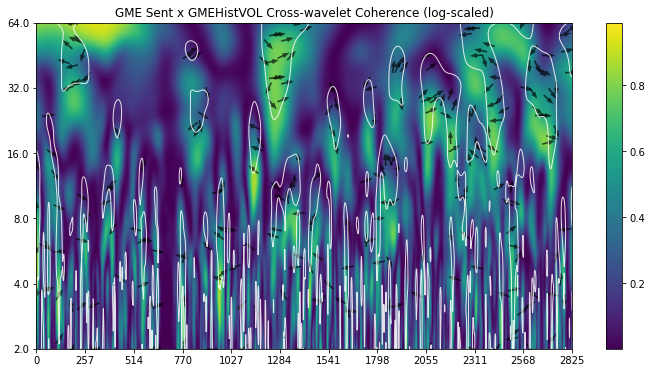

In [275]:
fig, ax = plt.subplots(figsize = (12,6))
t1 = np.arange(0, s1.size, 1)
# ax2.imshow(WCT, cmap = "viridis", extent = extent_corr, interpolation = "bilinear")
extent_im = [t1.min(), t1.max(), 0, max(np.log2(cor_period))]
im = ax.imshow(WCT, origin = "lower", interpolation = "bilinear", aspect = "auto", extent = extent_im, cmap = "viridis")
ax.contour(t1, np.log2(cor_period), cor_sig, [-99,1], colors = "w", linewidths = 1, extent = extent_corr, alpha = .85)
ax.set_ylim((1,6))
for t in range(0, len(t1), 20):
    cond = np.where(cor_sig[:,t]>=1) #significant periods within t
    if np.any(cond):
        for y in cond[0][::8]:
            ax.quiver(t1[t], np.log2(cor_period)[y], u[y,t], v[y,t],
                       units='height', angles='uv', pivot = 'mid', width = 0.005, scale = 25,
                       edgecolor='k', headwidth=3, headlength=4, alpha = .65)
yticks_cor = 2**np.arange(np.ceil(np.log2(cor_period.min())),
            np.ceil(np.log2(cor_period.max())))
ax.set_title("{} x {} Cross-wavelet Coherence (log-scaled)".format(data1['nick'], data2['nick']))
ax.set_yticks(np.log2(yticks_cor))
ax.set_yticklabels(yticks_cor)
# # ax2.set_xticklabels(data1['data'].index)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b%y'))
ax.xaxis.set_major_locator(pltticker.LinearLocator(numticks = 12))
ax.set_ylim((1,6))
fig.colorbar(im, ax = ax)
plt.show()

----
----
---

In [31]:
volsample = pd.concat([sampled_sent_lexadj.resample("1D").agg('sum'), gmevol], axis = 1).dropna(how="any").iloc[:,[3,5]]
# volsample.iloc[:,1] = standardize(volsample.iloc[:,1])
detrend(volsample.iloc[:,1])

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))
  0%|          | 0/300 [00:00<?, ?it/s]

Calculating wavelet coherence significance


100%|██████████| 300/300 [03:48<00:00,  1.31it/s]


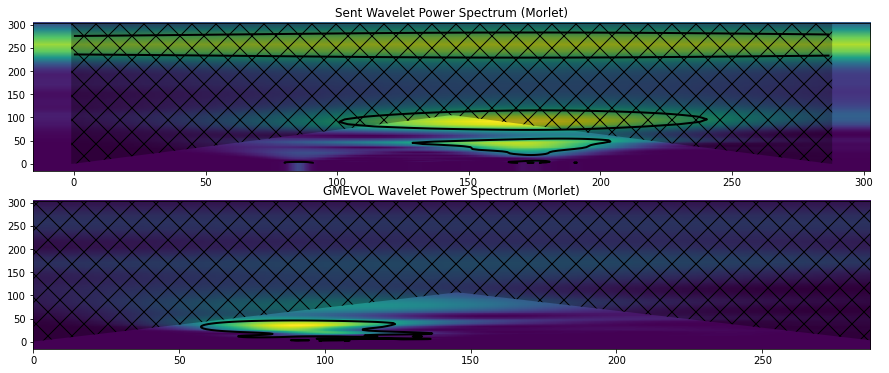

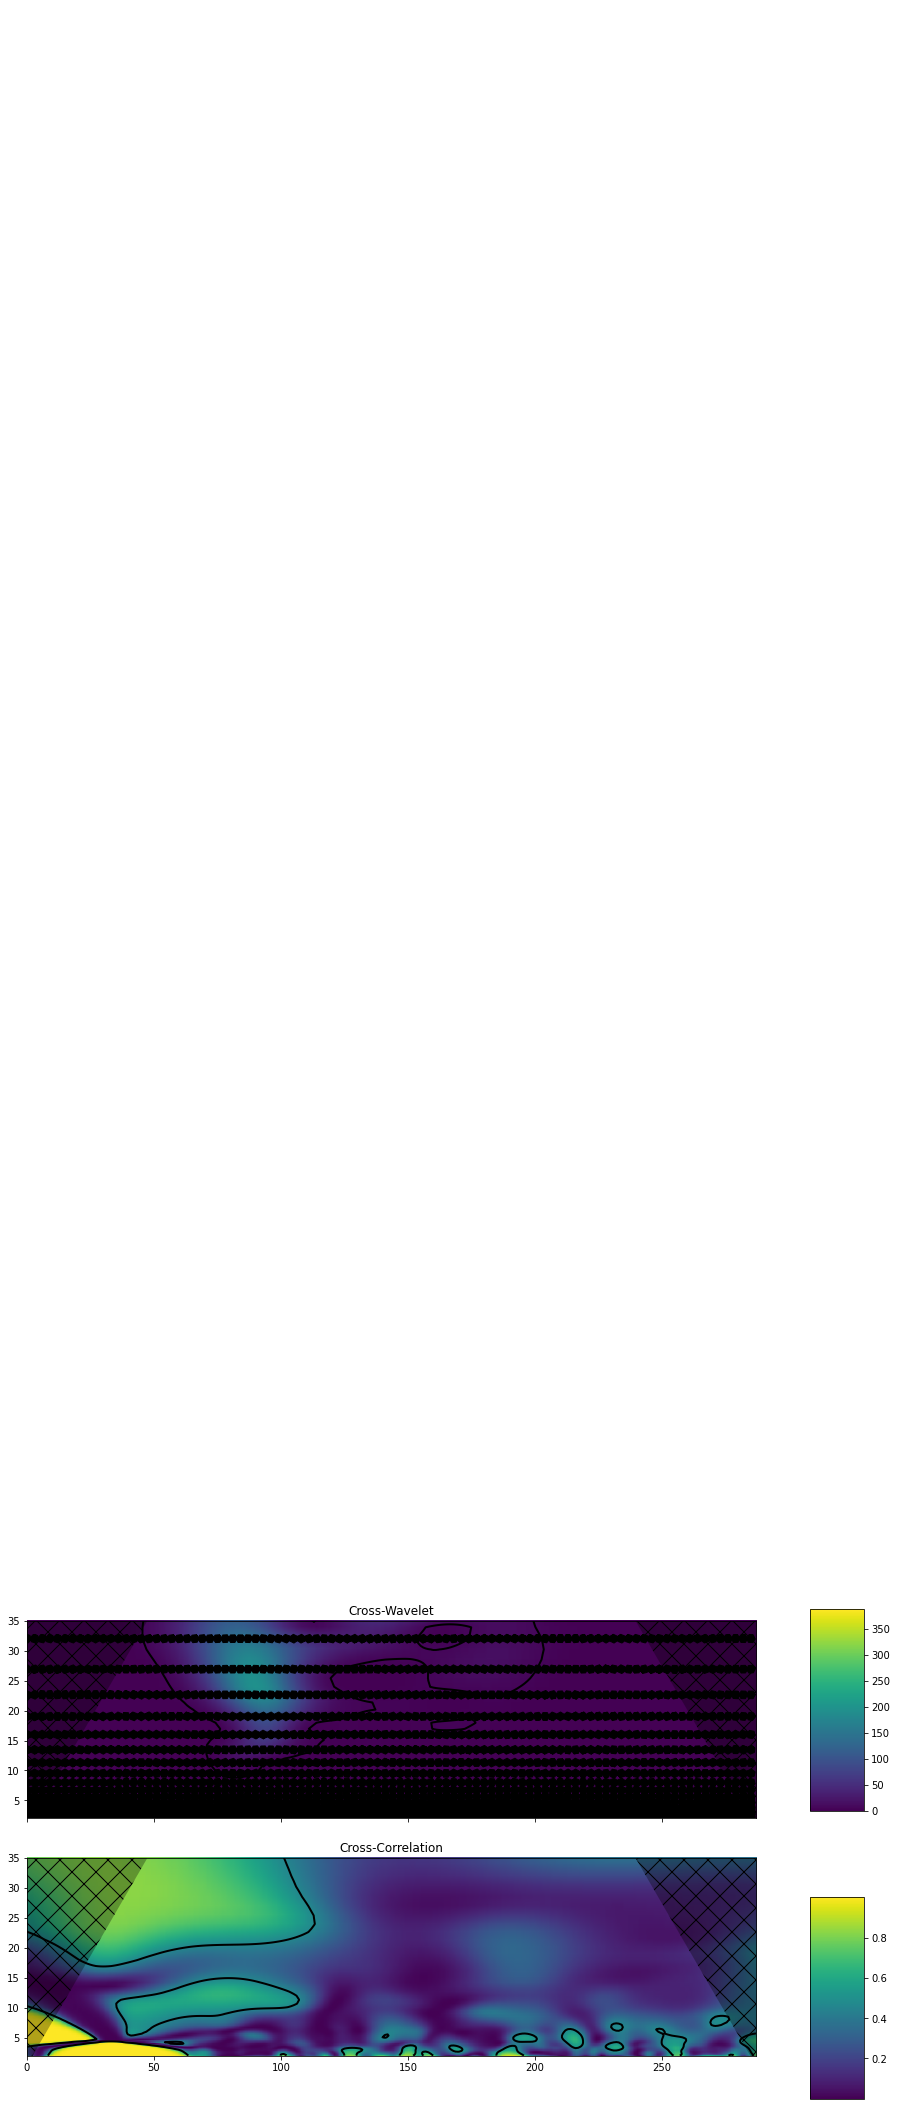

In [51]:
data1 = dict(name='Sentiment', nick='Sent')
data2 = dict(name='GME Volatility', nick='GMEVOL')
mother = 'morlet'

# s1 = np.array(sentiment_lexadj.resample("30min").agg("sum").compound.dropna())
# s1 = np.array(sampled_sent_lexadj.compound.dropna())
s1 = np.array(np.concatenate((np.repeat(0,s1.size/4),volsample.compound)))
s2 = np.array(np.concatenate((np.repeat(0,s1.size/4),detrend(volsample.iloc[:,1]))))
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,6))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format(data1['nick'],
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)


im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
# ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
#            angles='uv', pivot='mid', linewidth=1, edgecolor='k',
#            headwidth=10, headlength=10, headaxislength=5, minshaft=2,
#            minlength=5)
ax2.set_ylim(2, 35)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()

In [82]:
volsample = pd.concat([sampled_sent_lexadj.resample("1D").agg('sum'), gmevol], axis = 1).dropna(how="any")
# volsample.iloc[:,1] = standardize(volsample.iloc[:,1])
volsample.iloc[:,6]

2021-01-04    144.856900
2021-01-05    126.818500
2021-01-06    124.562200
2021-01-07    129.951800
2021-01-08    123.592900
                 ...    
2021-11-09     97.204600
2021-11-10     97.397400
2021-11-11     93.678500
2021-11-12     93.274100
2021-11-15     95.115942
Name: GME US Equity Implied Vol, Length: 220, dtype: float64

/Users/kevintrng/opt/anaconda3/lib/python3.8/site-packages/pycwt/wavelet.py:562: RuntimeWarning: invalid value encountered in arctanh
  aa = np.round(np.arctanh(np.array([al1, al2]) * 4))


NOTE: WCT significance loaded from cache.



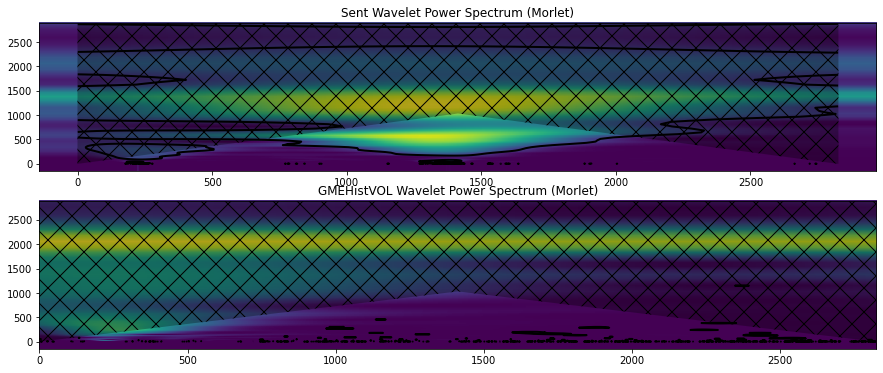

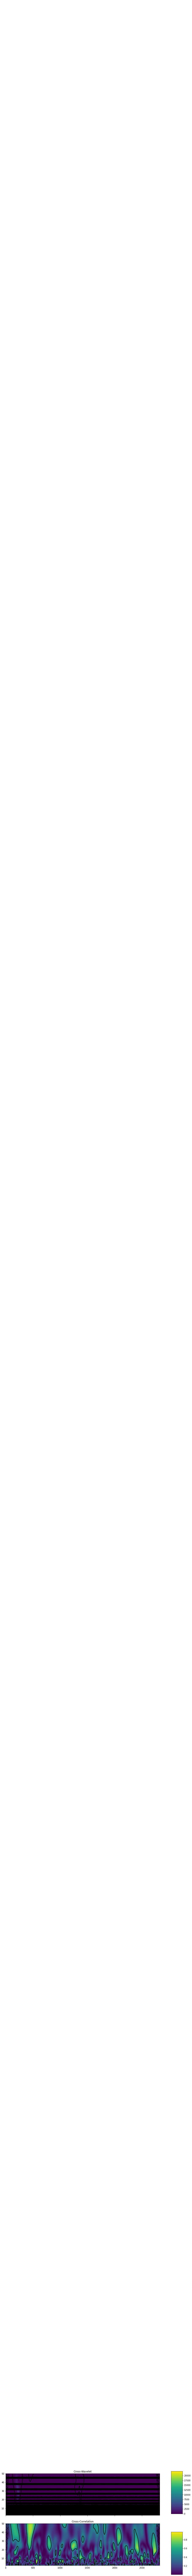

In [117]:
data1 = dict(name='Sentiment', nick='Sent')
data2 = dict(name='GME Hist Volatility', nick='GMEHistVOL')
mother = 'morlet'

s1 = np.array(sample.compound[9:])
s2 = np.array(sample.Close.rolling(10).std().dropna()*np.sqrt(250)*100)
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,6))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format(data1['nick'],
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)


im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
# ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
#            angles='uv', pivot='mid', linewidth=1, edgecolor='k',
#            headwidth=10, headlength=10, headaxislength=5, minshaft=2,
#            minlength=5)
ax2.set_ylim(2, 50)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()

# Appendix

In [ ]:
data1 = dict(name='GameStop Sentiment', nick='GME Sent', data = data.Sentiment)
data2 = dict(name='GameStop', nick='GME', data = data.GME)
mother = 'morlet'

# 2 series
s1 = np.array(data1['data'])
s2 = np.array(data2['data'])

#t vectors
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)

#delta
dt = np.diff(t1)[0]

#dataset sizes
n1, n2 = t1.size, t2.size
n = min(n1,n2)

#standard devs
std1, std2 = s1.std(), s2.std()

#wavelet parameters
mother = wavelet.Morlet(6) #mother wavelet with omega0 = 6
slevel = .95 #significance testing
dj = 1/12 #12 suboctaves per octave
s0 = -1 #starting scale
J = -1 #7 powers of two with dj sub-octaves

if True:
    #red noise
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    #white noise
    alpha1 = alpha2 = 0.0
    
#Wavelet transform and significance testing

## Returns wavelet transform according to mother wavelet,vector of scales, fourier freqs,
## cone of influence, Normalized fast Fourier transform and Fourier frequencies (in 1/time units) for the calculated
## FFT spectrum.
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)
W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2, significance_level=slevel, wavelet = mother)

#Normalised wavelet power spectra
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2

#extend signif1,signif2 into n1,n2 number of columns and to divide power spectra and determined singificance based on ratio
#power is significant when ratio > 1
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1/sig95_1

sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2/sig95_2

#Plot Continuous Wavelet Transform
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = (12,8))

extent1 = [t1.min(), t1.max(), 0, max(period1)]
extent2 = [t2.min(), t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation="bilinear", cmap = "viridis", extent = extent1)
##set x, y and z (depth)
im1.set_data(t1, period1, power1)

ax1.images.append(im1)
#levels = contours from any contours -99 and 1 (>1 meaning significant power)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors = "white", linewidths = .8, extent = extent1)
#cone of influence, by filling in rectangle set by coordinates
#spacing from edges ensured by +dt and -dt
#y axis set by cone of influence values, left bottom corner and top
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
#          np.concatenate([coi1, [], [2500], np.array([2000]), [1e-9]]),
         'k', alpha=0.25, hatch = "x")
ax1.set_title(f"{data1['nick']} Wavelet Power Spectrum ({mother.name})")

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))
# ax2.set_xticks(sample.index)
plt.show() 

W12, cross_coi, freq, signif = wavelet.xwt(y1 = s1, y2 = s2, dt = dt, dj = 1/12, s0 = -1, J = -1,
                                           significance_level=0.8646,
                                           wavelet = "morlet", normalize = True
                                          )
cross_power = np.abs(W12)**2
cross_sig = np.ones([1,n]) * signif[:, None]
cross_sig = cross_power/cross_sig #significant power if ratio > 1
cross_period = 1/freq

WCT, aWCT, corr_coi, freq, sig = wavelet.wct(y1 = s1, y2 = s2,
                                             dt = dt, dj = 1/12, s0 = -1, J = -1,
                                             significance_level = .8646,
                                             wavelet = "morlet", normalize = True,
                                             cache = True
                                            )

cor_sig = np.ones([1,n])*sig[:,None]
cor_sig = np.abs(WCT)/cor_sig #ratio > 1, power significant
cor_period = 1/freq

#Phases
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (15,8))
fig.subplots_adjust(right = 0.8)
cbar_ax = fig.add_axes([.85,0.55,0.05,0.35])
cbar_ax_1 = fig.add_axes([.85,0.05,0.05,0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent_cross)
im1.set_data(t1,cross_period,cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99,1], colors = "w", linewidths = 1, extent = extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],cross_period[-1:], [1e-9]]),
         'k', alpha=0.2, hatch='x')
ax1.set_title("GME Sentiment Cross-Wavelet")
fig.colorbar(im1, cax = cbar_ax)

im2 = NonUniformImage(ax2, interpolation="bilinear", extent = extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors = 'w', linewidths = 1, extent = extent_corr)
ax2.axis('tight')

for t in range(0, len(t1), 4):
    cond = np.where(cor_sig[:,t]>=1)
    if np.any(cond):
        for y in np.transpose(cond):
            ax2.quiver(t1[t], cor_period[y[0]], u[y[0],t], v[y[0],t], units = "height",
                       angles='uv',pivot='mid', edgecolor = "k",
                       headwidth = 10, headlength = 5, headaxislength = 5, minshaft = 8, minlength = 0.5
                      )
            
        
#     for y in range(0,len(cor_period),5):
#         ax2.quiver(t1[x], cor_period[y], u[y,x], v[y,x], units='height',
#            angles='uv', pivot='mid', linewidth=1, edgecolor='k',
#            headwidth=.10, headlength=.10, headaxislength=.5, minshaft=.2,
#            minlength=.5)a
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)
ax2.set_ylim([2,35])
plt.draw()
plt.show()

In [ ]:
data1 = dict(name='GameStop', nick='GME')
data2 = dict(name='AMC', nick='AMC')
mother = 'morlet'

# s1 = np.array(sentiment_lexadj.resample("30min").agg("sum").compound.dropna())
# s1 = np.array(sampled_sent_lexadj.compound.dropna())
s1 = np.array(gme_standardised.dropna())
s2 = np.array(amc_standardised.dropna())
timestamps1 = [i.timestamp() for i in sampled_sent_lexadj.compound.dropna().index]
timestamps2 = [i.timestamp() for i in amc_standardised.dropna().index]
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,8))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format("GMESENT",
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 15

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)
ax2.set_ylim(2, 35)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()

In [ ]:
data1 = dict(name='GameStop', nick='GME')
data2 = dict(name='Blackberry', nick='BB')
mother = 'morlet'

# s1 = np.array(sentiment_lexadj.resample("30min").agg("sum").compound.dropna())
# s1 = np.array(sampled_sent_lexadj.compound.dropna())
s1 = np.array(gme_standardised.dropna())
s2 = np.array(bb_standardised.dropna())
timestamps1 = [i.timestamp() for i in gme_standardised.dropna().index]
timestamps2 = [i.timestamp() for i in bb_standardised.dropna().index]
t1 = np.arange(0, s1.size, 1)
t2 = np.arange(0, s2.size, 1)
# t1 = np.array(timestamps1)
# t2 = np.array(timestamps2)
dt = np.diff(t1)[0]
n1 = t1.size
n2 = t2.size
n = min(n1,n2)

std1 = s1.std()
std2 = s2.std()

mother = wavelet.Morlet(6)
slevel = .95
dj = 1/12
s0 = -1
J = -1

if True:
    alpha1, _, _ = wavelet.ar1(s1)
    alpha2, _, _ = wavelet.ar1(s2)
else:
    alppha1 = alpha2 = 0.0
    
W1, scales1, freqs1, coi1, _, _ = wavelet.cwt(s1/std1, dt, dj, s0, J, mother)
signif1, fft_theor1 = wavelet.significance(1.0, dt, scales1, 0, alpha1, significance_level=slevel, wavelet = mother)

W2, scales2, freqs2, coi2, _, _ = wavelet.cwt(s2/std2, dt, dj, s0, J, mother)
signif2, fft_theor2 = wavelet.significance(1.0, dt, scales2, 0, alpha2,
                                           significance_level=slevel,
                                           wavelet=mother)
power1 = (np.abs(W1))**2
power2 = (np.abs(W2))**2
period1 = 1/freqs1
period2 = 1/freqs2
sig95_1 = np.ones([1, n1]) * signif1[:, None]
sig95_1 = power1 / sig95_1  
sig95_2 = np.ones([1, n2]) * signif2[:, None]
sig95_2 = power2 / sig95_2  

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=False, figsize = (15,8))

extent1 = [t1.min(),t1.max(), 0, max(period1)]
extent2 = [t2.min(),t2.max(), 0, max(period2)]

im1 = NonUniformImage(ax1, interpolation = "bilinear", extent = extent1)
im1.set_data(t1, period1, power1)
ax1.images.append(im1)
ax1.contour(t1, period1, sig95_1, [-99, 1], colors="k", linewidths=2,
            extent=extent1)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([coi1, [1e-9], period1[-1:], period1[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('{} Wavelet Power Spectrum ({})'.format("GMESENT",
                                                      mother.name))

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent2)
im2.set_data(t2, period2, power2)
ax2.images.append(im2)
ax2.contour(t2, period2, sig95_2, [-99, 1], colors='k', linewidths=2,
            extent=extent2)
ax2.fill(np.concatenate([t2, t2[-1:]+dt, t2[-1:]+dt, t2[:1]-dt, t2[:1]-dt]),
         np.concatenate([coi2, [1e-9], period2[-1:], period2[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
ax2.set_title('{} Wavelet Power Spectrum ({})'.format(data2['nick'],
                                                      mother.name))

#  II. Cross-wavelet transform
# ===========================

# Due to the difference in the time series, the second signal has to be
# trimmed for the XWT process.
s2 = s2[np.argwhere((t2 >= min(t1)) & (t2 <= max(t1))).flatten()]

# Calculate the cross wavelet transform (XWT). The XWT finds regions in time
# frequency space where the time series show high common power. Torrence and
# Compo (1998) state that the percent point function -- PPF (inverse of the
# cumulative distribution function) -- of a chi-square distribution at 95%
# confidence and two degrees of freedom is Z2(95%)=3.999. However, calculating
# the PPF using chi2.ppf gives Z2(95%)=5.991. To ensure similar significance
# intervals as in Grinsted et al. (2004), one has to use confidence of 86.46%.
W12, cross_coi, freq, signif = wavelet.xwt(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                           significance_level=0.8646,
                                           wavelet='morlet', normalize=True)

cross_power = np.abs(W12)**2
cross_sig = np.ones([1, n]) * signif[:, None]
cross_sig = cross_power / cross_sig  # Power is significant where ratio > 1
cross_period = 1/freq

# Calculate the wavelet coherence (WTC). The WTC finds regions in time
# frequency space where the two time seris co-vary, but do not necessarily have
# high power.
WCT, aWCT, corr_coi, freq, sig = wavelet.wct(s1, s2, dt, dj=1/12, s0=-1, J=-1,
                                             significance_level=0.8646,
                                             wavelet='morlet', normalize=True,
                                             cache=True)

cor_sig = np.ones([1, n]) * sig[:, None]
cor_sig = np.abs(WCT) / cor_sig  # Power is significant where ratio > 1
cor_period = 1 / freq

# Calculates the phase between both time series. The phase arrows in the
# cross wavelet power spectrum rotate clockwise with 'north' origin.
# The relative phase relationship convention is the same as adopted
# by Torrence and Webster (1999), where in phase signals point
# upwards (N), anti-phase signals point downwards (S). If X leads Y,
# arrows point to the right (E) and if X lags Y, arrow points to the
# left (W).
angle = 0.5 * np.pi - aWCT
u, v = np.cos(angle), np.sin(angle)
qfil = 15

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize = (15,8))
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.55, 0.05, 0.35])
cbar_ax_1 = fig.add_axes([0.85, 0.05, 0.05, 0.35])

extent_cross = [t1.min(), t1.max(), 0, max(cross_period)]
extent_corr = [t1.min(), t1.max(), 0, max(cor_period)]
im1 = NonUniformImage(ax1, interpolation='bilinear', extent=extent_cross)
im1.set_data(t1, cross_period, cross_power)
ax1.images.append(im1)
ax1.contour(t1, cross_period, cross_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_cross)
ax1.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([cross_coi, [1e-9], cross_period[-1:],
                         cross_period[-1:], [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax1.set_title('Cross-Wavelet')
ax1.quiver(t1[::qfil], cross_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil],
           units='width', angles='uv', pivot='mid', linewidth=1,
           edgecolor='k', headwidth=10, headlength=10, headaxislength=5,
           minshaft=2, minlength=5)
fig.colorbar(im1, cax=cbar_ax)

im2 = NonUniformImage(ax2, interpolation='bilinear', extent=extent_corr)
im2.set_data(t1, cor_period, WCT)
ax2.images.append(im2)
ax2.contour(t1, cor_period, cor_sig, [-99, 1], colors='k', linewidths=2,
            extent=extent_corr)
ax2.fill(np.concatenate([t1, t1[-1:]+dt, t1[-1:]+dt, t1[:1]-dt, t1[:1]-dt]),
         np.concatenate([corr_coi, [1e-9], cor_period[-1:], cor_period[-1:],
                         [1e-9]]),
         'k', alpha=0.3, hatch='x')
ax2.set_title('Cross-Correlation')
ax2.quiver(t1[::qfil], cor_period[::qfil], u[::qfil, ::qfil], v[::qfil, ::qfil], units='height',
           angles='uv', pivot='mid', linewidth=1, edgecolor='k',
           headwidth=10, headlength=10, headaxislength=5, minshaft=2,
           minlength=5)
ax2.set_ylim(2, 35)
ax2.set_xlim(max(t1.min(), t2.min()), min(t1.max(), t2.max()))
fig.colorbar(im2, cax=cbar_ax_1)

plt.draw()
plt.show()